## How to generate text: using different decoding methods for language generation with Transformers

In [1]:
import math
import random
import os
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
import json
import scipy.stats
import matplotlib.pyplot as plt
from peft import PeftModel
import collections

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# base model
base_path="../models/phi-2"  

# adapters: path to folder with adapter_model.safetensors
adapter_path="../models/phi-2-mlb/checkpoint-13100" 
      
# # Load model and tokenizer
base_model = AutoModelForCausalLM.from_pretrained(
    base_path,
    torch_dtype=torch.bfloat16,
).to(device)


if torch.cuda.device_count() > 1: # If more than 1 GPU
    base_model.is_parallelizable = False
    base_model.model_parallel = False

tokenizer = AutoTokenizer.from_pretrained(base_path)

# # Add/set tokens same tokens to base model before merging, like we did before training  
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))

base_model.config.eos_token_id = tokenizer.eos_token_id

# Load LoRA and merge
merged_model = PeftModel.from_pretrained(base_model, adapter_path).to(device)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


bin e:\src\transformer-sketchbook\.venv\lib\site-packages\bitsandbytes\libbitsandbytes_cuda121.dll


In [6]:
from datasets import load_dataset,DatasetDict
dataset = load_dataset("json", data_files='../data/2011_2023_phi-2_struct_encoded.json',field="test", split='all')
# dataset = eval_dataset[-1000:]


In [11]:
len(dataset['text'])

22

In [8]:
temp_set = []
valid_set = []
for i in dataset['text']:
   split_input = i.split("Output: ")
   temp = split_input[0]
   temp_set.append(f"{temp}Output: ")
   try:
      valid = json.loads(split_input[-1])
      valid_set.append(valid['event'])
   except:
      valid = {}
      valid_set.append("")
      pass
   

test_set = temp_set

In [12]:
def remove_last_newline(s):
    last_newline_index = s.rfind('\n')  # Find the index of the last newline character
    if last_newline_index != -1:  # Check if newline character exists
        s = s[:last_newline_index]  # Remove the newline character
    return s

In [13]:
def extract_between_quotes(s):
    first_quote_index = s.find('"')
    if first_quote_index != -1:
        second_quote_index = s.find('"', first_quote_index + 1)
        if second_quote_index != -1:
            return s[first_quote_index + 1:second_quote_index]
    print(s)
    return None

In [25]:
from decimal import Decimal
from pandas._libs.missing import NAType

class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if obj is None:
            return ""
        if isinstance(obj, Decimal):
            return str(obj)
        if isinstance(obj, NAType):
            return ""
        # 👇️ otherwise use the default behavior
        return json.JSONEncoder.default(self, obj)

### Generate the Probabilities  

In [36]:
# encode context the generation is conditioned on
samples = []
json_data = []
obp_data= []
j = test_set[0]
output_data = {}
num_returns = 100
player_count = 0
results = []
event = 0
for j in test_set:    
    input_tokens = tokenizer(j, return_tensors="pt").to(device)
    output_tokens = merged_model.generate(**input_tokens, max_new_tokens=15, do_sample=True, top_k=40, temperature=1, output_scores=True, return_dict_in_generate=True, num_return_sequences=num_returns)
    format_json = remove_last_newline(j.replace("Instruct: ", "").replace(".", ""))
    input_json = json.loads(format_json)
    gen_sequences = output_tokens.sequences[:, input_tokens['input_ids'].shape[-1]:]
    keys = []
    probs_for_graph = {}
    probs_for_graph['out'] = 0
    probs_for_graph['hit'] = 0
    probs_for_graph['obp'] = 0
    probs_for_graph['single'] = 0
    probs_for_graph['double'] = 0
    probs_for_graph['triple'] = 0
    probs_for_graph['home_run'] = 0
   
    for i in output_tokens.sequences:
        output_decode =tokenizer.decode(
            i[len(input_tokens[0]):],
            skip_special_tokens=True
            )
        if "single" in output_decode:
            keys.append("single")
        elif "double_play" in output_decode:
            keys.append("double_play")
        elif "triple_play" in output_decode:
            keys.append("triple_play")
        elif "triple" in output_decode:
            keys.append("triple")
        elif "double" in output_decode:
            keys.append("double")
        elif "home_run" in output_decode:
            keys.append("home_run")
        elif "field_out" in output_decode:
            keys.append("field_out")
        elif "fielders_choice_out" in output_decode:
            keys.append("fielders_choice_out")
        elif "fielders_choice" in output_decode:
            keys.append("fielders_choice")
        elif "field_out" in output_decode:
            keys.append("field_out")
        elif "sac_bunt" in output_decode:
            keys.append("sac_bunt")
        elif "force_out" in output_decode:
            keys.append("force_out")
        elif "strikeout" in output_decode:
            keys.append("strikeout")
        elif "field_error" in output_decode:
            keys.append("field_error")
        elif "hit_by_pitch" in output_decode:
            keys.append("hit_by_pitch")
        elif "walk" in output_decode:
            keys.append("walk")
        elif "caught_stealing_2b" in output_decode:
            keys.append("caught_stealing_2b")
        elif "sac_fly" in output_decode:
            keys.append("sac_fly")
        elif 'foul_tip' in output_data:
            keys.append("foul_tip")
        elif 'bunt' in output_data:
            keys.append('bunt')
        else:
            print(output_decode)
            keys.append("+")

    probs = torch.stack(output_tokens.scores, dim=1).softmax(-1)
    gen_probs = torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)
    unique_prob_per_sequence = gen_probs.prod(-1).cpu().numpy()
    count = 0
    
    for k in keys:
        if k is not None and k != "+":
            if k not in probs_for_graph:
                probs_for_graph[k] = float(unique_prob_per_sequence[count])
            else:
                probs_for_graph[k] += float(unique_prob_per_sequence[count])
                probs_for_graph[k] /= 2

        count+=1

    for k in probs_for_graph:
        if 'single' in k or ('double' == k) or ('triple' == k) or 'home_run' in k:
            probs_for_graph['hit'] += float(probs_for_graph[k])
            probs_for_graph['obp'] += float(probs_for_graph[k])
        elif 'walk' in k or 'hit_by_pitch' in k or 'field_error' in k or 'fielders_choice' in k:
            probs_for_graph['obp'] += float(probs_for_graph[k])
        else:
            probs_for_graph['out'] +=float( probs_for_graph[k])
            
    
    # obp_data.append(probs_for_graph['obp'])
    event_key = f"{input_json['batter']['name']}_{input_json['batter']['id']}_v_{input_json['pitcher']['id']}_{input_json['pitcher']['name']}_{event}"
    od = collections.OrderedDict(sorted(probs_for_graph.items()))
    output_data[event_key] = {
                                "actual":valid_set[event],
                                "events":dict(sorted(od.items(), key=lambda item: item[1], reverse=True)),
                                "odds":{
                                    "hit_3":float((1-math.pow(1-probs_for_graph['hit'], 3))/(1-(1-math.pow(1-probs_for_graph['hit'], 3)))),
                                    "hit_4":float((1-math.pow(1-probs_for_graph['hit'], 4))/(1-(1-math.pow(1-probs_for_graph['hit'], 4)))),
                                    "single_3":float((1-math.pow(1-probs_for_graph['single'], 3))/(1-(1-math.pow(1-probs_for_graph['single'], 3)))),
                                    "single_4":float((1-math.pow(1-probs_for_graph['single'], 4))/(1-(1-math.pow(1-probs_for_graph['single'], 4)))),
                                    "double_3":float((1-math.pow(1-probs_for_graph['double'], 3))/(1-(1-math.pow(1-probs_for_graph['double'], 3)))),
                                    "double_4":float((1-math.pow(1-probs_for_graph['double'], 4))/(1-(1-math.pow(1-probs_for_graph['double'], 4)))),
                                    "triple_3":float((1-math.pow(1-probs_for_graph['triple'], 3))/(1-(1-math.pow(1-probs_for_graph['triple'], 3)))),
                                    "triple_4":float((1-math.pow(1-probs_for_graph['triple'], 4))/(1-(1-math.pow(1-probs_for_graph['triple'], 4)))),
                                    "home_run_3":float((1-math.pow(1-probs_for_graph['home_run'], 3))/(1-(1-math.pow(1-probs_for_graph['home_run'], 3)))),
                                    "home_run_4":float((1-math.pow(1-probs_for_graph['home_run'], 4))/(1-(1-math.pow(1-probs_for_graph['home_run'], 4))))
                                }
                                
    }
    event+=1

with open('../data/predictions.json', 'w', encoding='utf-8') as f:
    json.dump(output_data, f, ensure_ascii=True, indent=4, allow_nan=True, cls=MyEncoder)

    # highest_prob = max(output_data[event_key].values())

    # Find the key associated with the largest value
    # for key, value in output_data[event_key].items():
    #     if value == highest_prob:
    #         highest_prob_key = key
    #         break
    # print("-"*100)
    # print(highest_prob_key)
    # print(valid_set[player_count])
    # if valid_set[player_count] in output_data[event_key].keys():
    #     results.append({
    #         "highest":highest_prob,
    #         "actual":output_data[event_key][valid_set[player_count]],
    #         "correct":valid_set[player_count]==highest_prob_key,
    #         "highest_key":highest_prob_key,
    #         "actual_event":valid_set[player_count]
    #     })
    # else:
    #     results.append({
    #         "highest":highest_prob,
    #         "actual":0.0,
    #         "correct":valid_set[player_count]==highest_prob_key,
    #         "highest_key":highest_prob_key,
    #         "actual_event":valid_set[player_count]
    #     })

    # labels = list(output_data[event_key].keys())
    # values = list(output_data[event_key].values())
    # Plotting the bar graph
    # plt.figure(figsize=[20,7])
    # plt.bar([valid_set[player_count]], [100])
    # plt.bar(labels, values)
    # plt.title(f"{key}")
    # plt.xlabel('Events')
    # plt.ylabel(f'P(E)%')
    # plt.savefig(f"../data/mlb_images/{event_key}_{player_count:08d}.png")
    # plt.show()
    # player_count+= 1

# plt.figure(figsize=[20,7])
# plt.plot(range(len(obp_data)), obp_data)
# plt.title(f"all players")
# plt.xlabel('player')
# plt.ylabel(f'on base percentage')
# plt.savefig(f"../data/mlb_images/{key}_{player_count}.png")
# plt.show()
# player_count+= 1



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
output_data

TypeError: Object of type float32 is not JSON serializable

In [ ]:
for player in output_data:
    probs_for_graph = output_data[player]
    for k in probs_for_graph:
        print(f"{player} {k} {probs_for_graph[k]}")

brian mccann v livan hernandez hit 0.27834413677919656
brian mccann v livan hernandez field_out 0.1706083056051284
brian mccann v livan hernandez field_error 0.0306896660476923
brian mccann v livan hernandez single 0.14150930114556104
brian mccann v livan hernandez home_run 0.05396999046206474
brian mccann v livan hernandez Breyvic Valera 3.872096599518565e-14
brian mccann v livan hernandez double 0.08286484517157078
brian mccann v livan hernandez hit_by_pitch 0.03344918042421341
dan uggla v livan hernandez hit 0.05530586732857046
dan uggla v livan hernandez strikeout 0.08414404342602211
dan uggla v livan hernandez walk 0.1158951458055526
dan uggla v livan hernandez single 0.05530586732857046
dan uggla v livan hernandez field_out 0.23569287359714508
jason heyward v livan hernandez hit 0.0892951088026166
jason heyward v livan hernandez strikeout 0.04847012658137828
jason heyward v livan hernandez field_out 0.18825910142913926
jason heyward v livan hernandez triple 0.013544459827244282
j

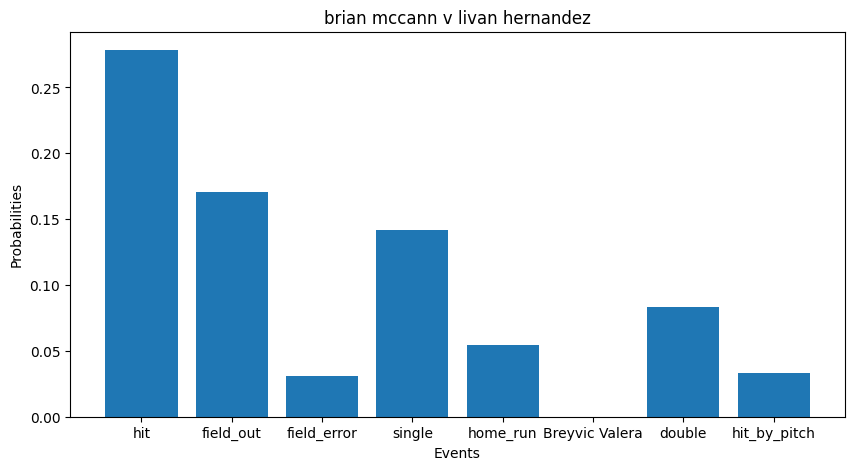

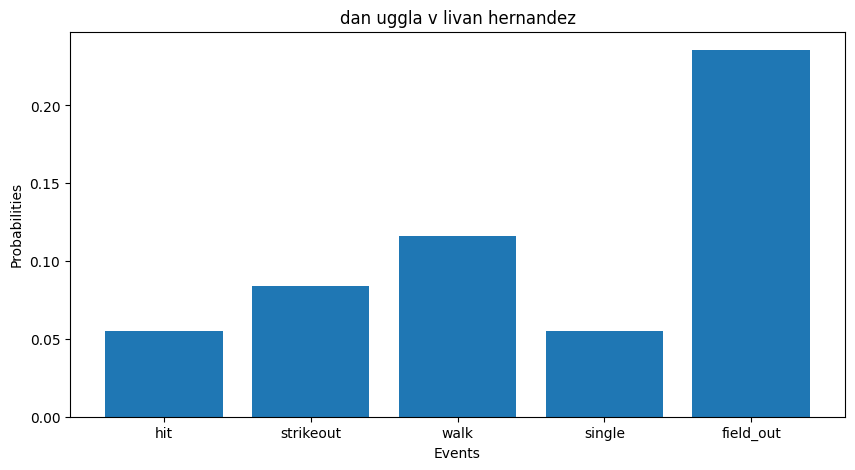

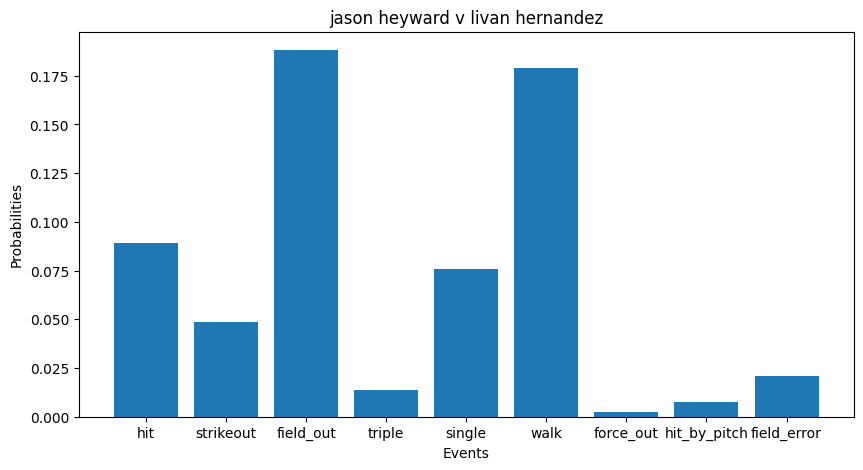

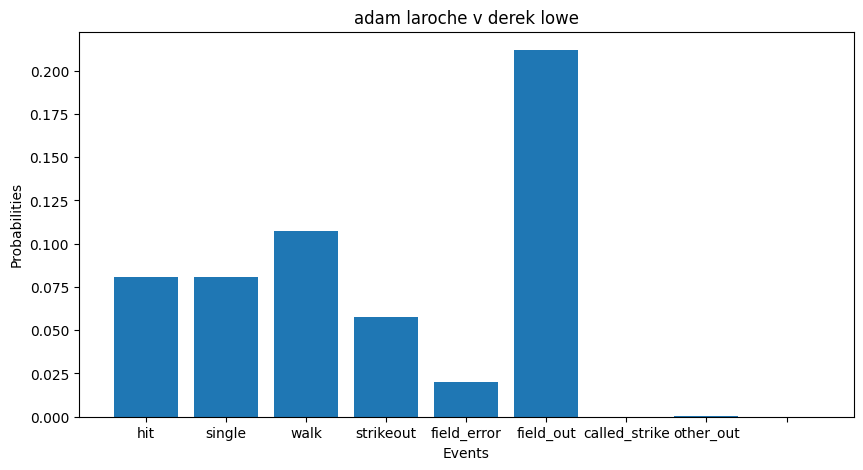

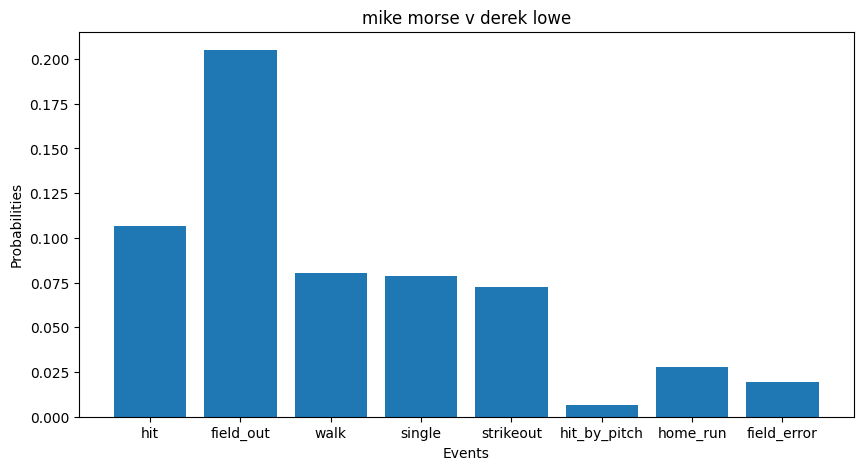

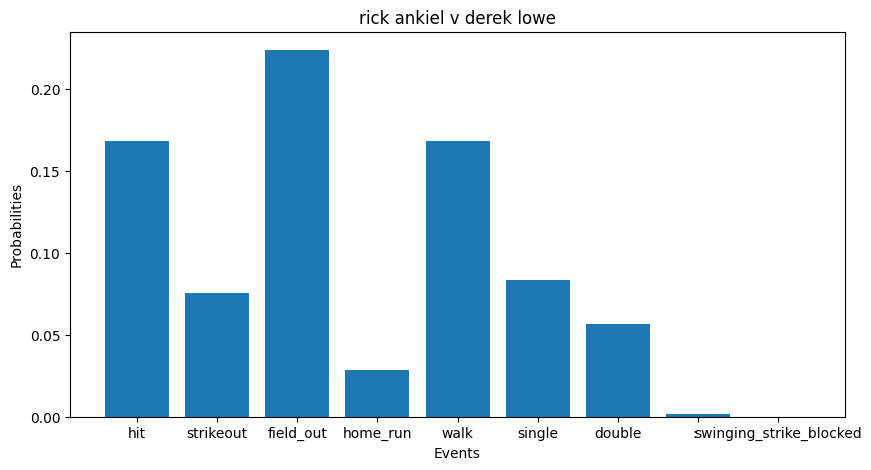

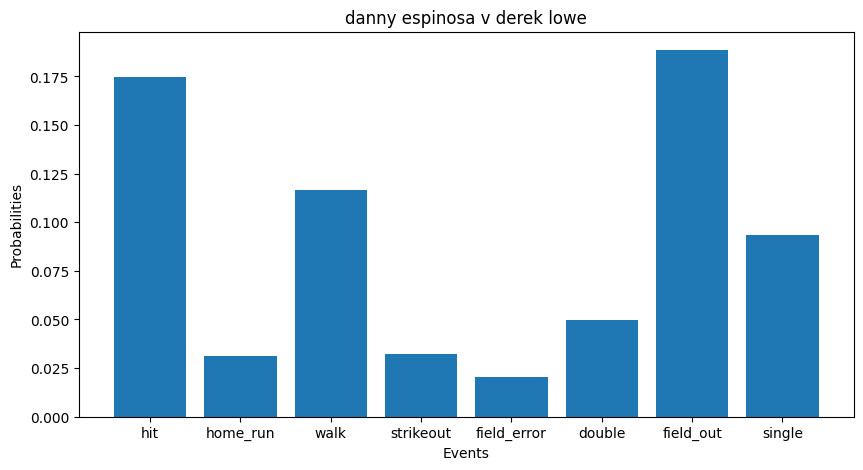

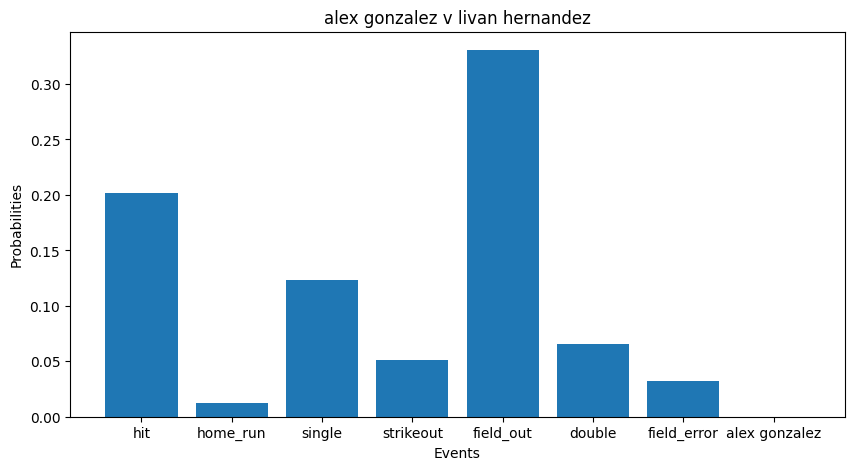

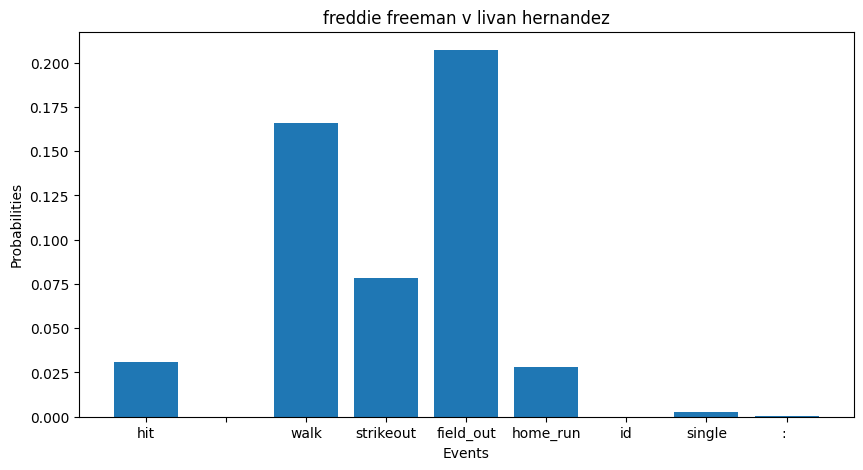

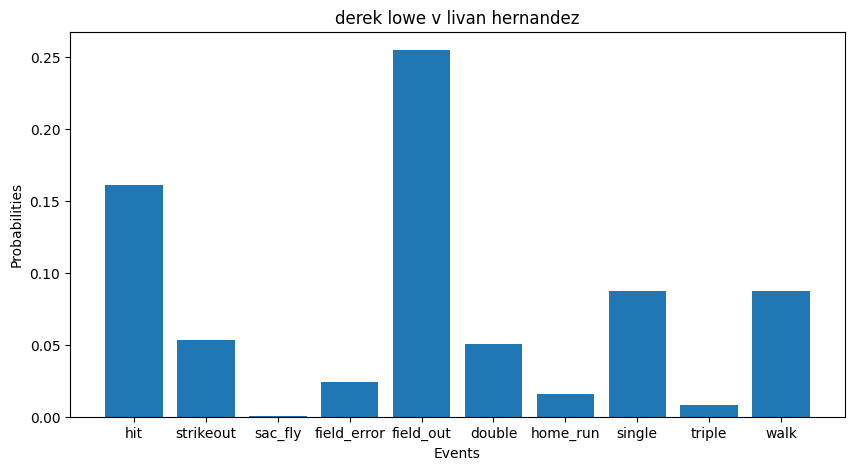

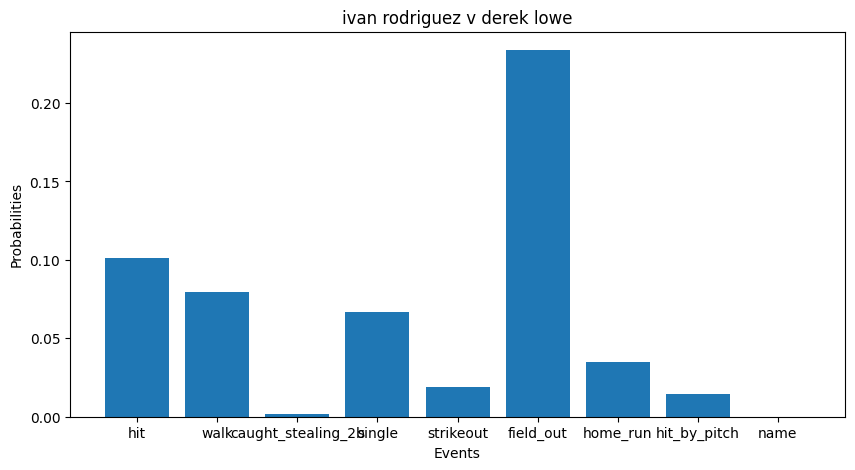

In [ ]:
for batter in output_data:
    labels = list(output_data[batter].keys())
    values = list(output_data[batter].values())
    # Plotting the bar graph
    plt.figure(figsize=[10,5])
    plt.bar(labels, values)
    plt.title(f"{batter}")
    plt.xlabel('Events')
    plt.ylabel(f'Probabilities')
    plt.savefig(f"{batter}.png")
    plt.show()